ODK forms can include [repeated sections](https://docs.getodk.org/form-logic/#repeating-questions). These are like subforms linked to the parent or base form. The data for each repeat is represented in a separate table.

When processing data, you can sometimes work with the base form and any repeats entirely separately. For example, in your form design, you may have calculated a summary of the repeats in the base form or copied values you need for analysis into your repeats. Sometimes you do need to connect them and the examples below provide some ways to do so. 

The form used in the examples below is [simple_repeat.xlsx](simple_repeat.xlsx).

## Get data from the base form and the repeat

First we get data from the base form. We can apply filters such as excluding rejected submissions.

In [68]:
from pyodk.client import Client
import pandas as pd

client = Client().open()
submissions = client.submissions.get_table(form_id='simple_repeat', filter="__system/reviewState ne 'rejected'")

When we use `client.submissions.get_table`, we get JSON back. We'd like to be able to use `pandas` for our analysis so we use [`json_normalize`](https://pandas.pydata.org/pandas-docs/version/1.2.4/reference/api/pandas.json_normalize.html) to go from JSON with nesting (ODK `groups`) to a pandas dataframe. We specify a separator of `/` to match other ODK exports (the default is to use `.` when separating groups )

In [69]:
subs_df = pd.json_normalize(data=submissions['value'], sep='/')
subs_df.head(3)

,__id,session_num,today,name,observation@odata.navigationLink,meta/instanceID,__system/submissionDate,__system/updatedAt,__system/submitterId,__system/submitterName,__system/attachmentsPresent,__system/attachmentsExpected,__system/status,__system/reviewState,__system/deviceId,__system/edits,__system/formVersion
0,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,24324,2022-10-10,Abosede Lynne,Submissions('uuid%3A782628f5-dd98-4676-8c62-cd...,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,2022-10-10T20:43:53.754Z,None,30,ln@nafundi.com,0,0,None,None,None,0,2022101001
1,uuid:013c334c-102a-4001-b637-569cf686ee7d,23455,2022-10-10,Kierra Reginald,Submissions('uuid%3A013c334c-102a-4001-b637-56...,uuid:013c334c-102a-4001-b637-569cf686ee7d,2022-10-10T20:27:21.232Z,None,30,ln@nafundi.com,0,0,None,None,None,0,2022101001
2,uuid:dbbe542b-72fe-42c7-9a2f-834c942e8104,2343,2022-10-05,Kierra Reginald,Submissions('uuid%3Adbbe542b-72fe-42c7-9a2f-83...,uuid:dbbe542b-72fe-42c7-9a2f-834c942e8104,2022-10-10T20:27:10.082Z,None,30,ln@nafundi.com,0,0,None,None,None,0,2022101001


Next we'll want to do the same thing for the repeat table:

In [70]:
repeats = client.submissions.get_table(form_id='simple_repeat', table_name='Submissions.observation', filter="__system/reviewState ne 'rejected'")
obs_df = pd.json_normalize(data=repeats['value'], sep='/')
obs_df.head(3)

,thing,count,notes,__id,__Submissions-id
0,Birds,7.0,Hard to see,fd198d7d6624599019de907673ab74aab7073111,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3
1,Frogs,23.0,Loud,3d36dc1bdd1a8e616e275f3f7f40b18a474c5fa3,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3
2,Plants,2.0,Not many here,bd8fea8681d96a0cf5b4ddb4113d10537196851f,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3


## Augment the repeats with the base data

For many analysis needs, it's helpful to augment the repeat data with data from the base form. To join dataframes in pandas, they must have columns with the same meaning. For ODK data, we can use `__id` from the parent and `__Submissions-id` from the repeats.

First we set `__id` to be the index of the base submission dataframe, then we build a new dataframe joining the two:

In [71]:
subs_df.set_index('__id', inplace=True)
joined_df = obs_df.join(subs_df, on="__Submissions-id")
joined_df.head(3)

,thing,count,notes,__id,__Submissions-id,session_num,today,name,observation@odata.navigationLink,meta/instanceID,...,__system/updatedAt,__system/submitterId,__system/submitterName,__system/attachmentsPresent,__system/attachmentsExpected,__system/status,__system/reviewState,__system/deviceId,__system/edits,__system/formVersion
0,Birds,7.0,Hard to see,fd198d7d6624599019de907673ab74aab7073111,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,24324,2022-10-10,Abosede Lynne,Submissions('uuid%3A782628f5-dd98-4676-8c62-cd...,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,...,None,30,ln@nafundi.com,0.0,0.0,None,None,None,0.0,2022101001
1,Frogs,23.0,Loud,3d36dc1bdd1a8e616e275f3f7f40b18a474c5fa3,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,24324,2022-10-10,Abosede Lynne,Submissions('uuid%3A782628f5-dd98-4676-8c62-cd...,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,...,None,30,ln@nafundi.com,0.0,0.0,None,None,None,0.0,2022101001
2,Plants,2.0,Not many here,bd8fea8681d96a0cf5b4ddb4113d10537196851f,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,24324,2022-10-10,Abosede Lynne,Submissions('uuid%3A782628f5-dd98-4676-8c62-cd...,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,...,None,30,ln@nafundi.com,0.0,0.0,None,None,None,0.0,2022101001


You can then do things like group by values in the base form, the repeat, or both. You can also use aggregating functions like sum.

Using `groupby` and `stack` is similar to using pivot tables in spreadsheet software. Pandas also provides [`pivot_table`](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) which is similar to what is shown below ([learn more](https://stackoverflow.com/a/72933069/137744)).

In [72]:
grouped = joined_df.groupby(['name', 'thing']).sum('count')[['count']]
grouped

count
name             thing        
Abosede Lynne    Birds     7.0
                 Frogs    23.0
                 Plants   15.0
Arnaude Antonius Birds     2.0
                 Frogs    45.0
                 Plants   12.0
Kierra Reginald  Birds    84.0
                 Plants   55.0

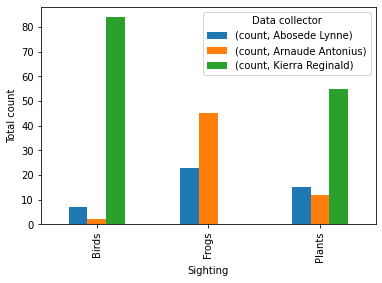

In [73]:
ax = grouped.unstack(level=0).plot(kind='bar')
ax.set_xlabel("Sighting")
ax.set_ylabel("Total count")
ax.legend().set_title("Data collector")

## Augment the parent data with "wide" repeats

Sometimes it can be helpful to work with all of the repeats on the same row as the submission. This is particularly useful when:

- The number of repeats is fixed and each repeat instance has a different meaning. For example, the first instance might be about mangos, the second about cassava and the third about bananas. Those will be analyzed separately.
- Responses in repeats are primarily qualitative and need to be read but not quantitatively analyzed.

In [74]:
from flatten_json import flatten_json

client = Client().open()
# The expand option includes all repeats in the json returned by get_table
submissions = client.submissions.get_table(form_id='simple_repeat', expand='*', filter="__system/reviewState ne 'rejected'")
# Flatten all repeats for each submission returned
df = pd.DataFrame([flatten_json(x) for x in submissions['value']])

# Drop system columns so we can see more of the repeats
df.drop(list(df.filter(regex = '__system')), axis = 1, inplace = True)
df.head(3)

,__id,session_num,today,name,meta_instanceID,observation@odata.navigationLink,observation_0_thing,observation_0_count,observation_0_notes,observation_0___id,observation_1_thing,observation_1_count,observation_1_notes,observation_1___id,observation_2_thing,observation_2_count,observation_2_notes,observation_2___id
0,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,24324,2022-10-10,Abosede Lynne,uuid:782628f5-dd98-4676-8c62-cdb2476e40d3,Submissions('uuid%3A782628f5-dd98-4676-8c62-cd...,Birds,7,Hard to see,fd198d7d6624599019de907673ab74aab7073111,Frogs,23.0,Loud,3d36dc1bdd1a8e616e275f3f7f40b18a474c5fa3,Plants,2.0,Not many here,bd8fea8681d96a0cf5b4ddb4113d10537196851f
1,uuid:013c334c-102a-4001-b637-569cf686ee7d,23455,2022-10-10,Kierra Reginald,uuid:013c334c-102a-4001-b637-569cf686ee7d,Submissions('uuid%3A013c334c-102a-4001-b637-56...,Birds,34,None,a4eabf3eb42c4e6685df5c451d986f9ae2a4fc90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,uuid:dbbe542b-72fe-42c7-9a2f-834c942e8104,2343,2022-10-05,Kierra Reginald,uuid:dbbe542b-72fe-42c7-9a2f-834c942e8104,Submissions('uuid%3Adbbe542b-72fe-42c7-9a2f-83...,Birds,35,None,e411132a5040cbc72b0447c8feef2944904f768a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
